### Sensor calibration - How to work with time series in Pandas


This notebook is originally part of a bigger project where I evaluated sensor calibration. Today, we're not going to show you the whole calibration process. We are going to focus on:

- How to import different time based log files
- How to smooth the data using floating average
- How to synchronize data - and join them based on the common timestamp

If you are interested in the original problem, you can read the following points

>* Have you ever wondered, how is it possible that you buy a temperature sensor / probe, plug it in and it immediately shows the temperature (the same applies for pressure, humidity, force, stress, strain, displacement, etc.). Yes, i know there is always some configuration at the beginning. But somehow the sensor can convert its raw physical quantity (voltage, current, etc.) into the desired quantity (temperature in our case)
>* Sensors (transducers) work very similar to our senses. An outer pehnomenon acts on the sensor, and the sensor changes its internal structure (e.g. voltage of the sensor changes with temperature). However, we are not interested in the voltage level of the sensor, we need to know the actual temperature. This is where the calibration comes into play - it helps to find the relationship between the voltage level and temperature (or any other pair of physical quantities)
>* Calibration is usually a process, where we are determine a relationship between a known sensor (usually called reference) and an unknown sensor (we can call it DUT - device under test)
>* The same conditions are apllied for the reference and the DUT. The data is collected from both devices, analyzed and the correlation between them is evaluated (this is everything in a nutshell)
>* The calibration comes right after the manufacturing of the sensor. In some cases the sensors should be recalibrated in regular intervals (If there is suspicion, that the relatonship is changing with time).

In [13]:
# Importing some useful libraries

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import pandas as pd
from numpy import random

In [14]:
# Strings holding filenames. All input files are located in the root folder of the notebook

logger1_file = "datasets/Logger1_abitrary_units.csv"
temperature_log_file = "datasets/Logger2_temperature_probe.csv"

* logger1 - represents the DUT. logger1_file - contains the data from the calibration
* temperature - represents the temperature reference. Usually its a very precise PT-100 temperature probe, calibrated / verified by a metrological institue

Note: The DUT and the reference can have different thermal response, different sensitivity, the scanning frequency of the loggers can be different as well.

**We can load in the from the DUT into a pandas dataframe
Every log file can have different number of columns, different format, data separators.
So the first task is to erase the unnecessary data, clean it and convert it to a format, 
which is compatible with the reference**

In [15]:
logger1_df = pd.read_table(logger1_file,
                           header=0,
                           sep=";",
                           decimal=",",
                           skipinitialspace=True,
                           skip_blank_lines=False)
logger1_df[logger1_df.columns[0]] = pd.to_datetime(logger1_df[logger1_df.columns[0]], format = "%d.%m.%Y %H:%M:%S.%f")
logger1_df[logger1_df.columns[0]] = pd.to_datetime(logger1_df[logger1_df.columns[0]])

In [16]:
logger1_df.head()

Timestamp  Unnamed: 1  Unnamed: 2  Unnamed: 3  Unnamed: 4  \
0 2017-04-19 15:18:02.209290           1           0           0           0   
1 2017-04-19 15:18:32.209290           1           0           0           0   
2 2017-04-19 15:19:06.209290           1           0           0           0   
3 2017-04-19 15:19:40.209290           1           0           0           0   
4 2017-04-19 15:20:10.209290           1           0           0           0   

   Unnamed: 5  Unnamed: 6  Unnamed: 7  Unnamed: 8  Unnamed: 9  Unnamed: 10  \
0           0           0           0           0           0            0   
1           0           0           0           0           0            0   
2           0           0           0           0           0            0   
3           0           0           0           0           0            0   
4           0           0           0           0           0            0   

   Unnamed: 11  Unnamed: 12  Unnamed: 13  Unnamed: 14  Unnamed: 15  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Unnamed: 16  Unnamed: 17  Unnamed: 18  
0            0          128       -35.00  
1            0          128       -35.06  
2            0          129       -34.90  
3            0          144       -34.93  
4            0          161       -35.09

In [17]:
# Now we need to erase the unnecessary columns and rename the important ones

logger1_df = logger1_df.drop(logger1_df.columns[list(range(1,17,1)) + [18]], axis=1)

In [18]:
# Rename the columns, so they have some meaningful names

logger1_df = logger1_df.rename(columns={logger1_df.columns[0]: 'Timestamp', logger1_df.columns[1]: 'Measured_value'})

In [19]:
logger1_df.head()

Timestamp  Measured_value
0 2017-04-19 15:18:02.209290             128
1 2017-04-19 15:18:32.209290             128
2 2017-04-19 15:19:06.209290             129
3 2017-04-19 15:19:40.209290             144
4 2017-04-19 15:20:10.209290             161

To check, if we imported everything corretly, we can plot the temperature values from the DUT

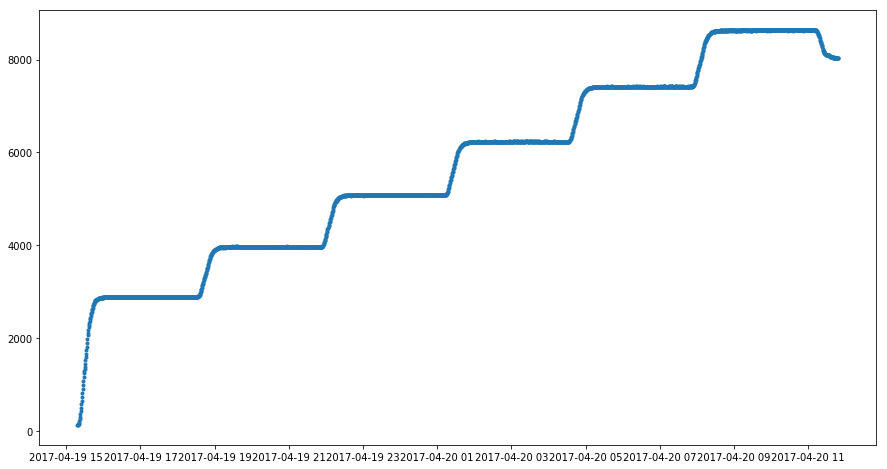

In [20]:
fig, ax = plt.subplots(figsize=(15,8))
ax.ticklabel_format(useOffset=False)
myFmt = mdates.DateFormatter('%Y-%m-%d %H') # set's the format of the timestamp on the x-axis
ax.xaxis.set_major_formatter(myFmt)


ax.plot(logger1_df.Timestamp, logger1_df.Measured_value, ".")

plt.show()

We need to do the same with data from the reference sensor

> It has a totally different structure, so import it with care

In [21]:
temperature_log_df = pd.read_table(temperature_log_file,
                                   decimal=',',
                                   header=1, 
                                   parse_dates=[["#Date","#Time"]],
                                   dayfirst=True)
temperature_log_df[temperature_log_df.columns[0]] = pd.to_datetime(temperature_log_df[temperature_log_df.columns[0]])

In [22]:
temperature_log_df.head()

#Date_#Time  #Temperature
0 2017-04-19 15:17:37.076900        25.053
1 2017-04-19 15:18:07.054900        24.986
2 2017-04-19 15:18:37.080900        24.971
3 2017-04-19 15:19:07.091900        25.386
4 2017-04-19 15:19:37.117900        26.233

In [23]:
# Again, rename the columns to something meaningful

temperature_log_df = temperature_log_df.rename(columns={temperature_log_df.columns[0]: 'Timestamp', 
                                               temperature_log_df.columns[1]: 'Reference_temperature'})

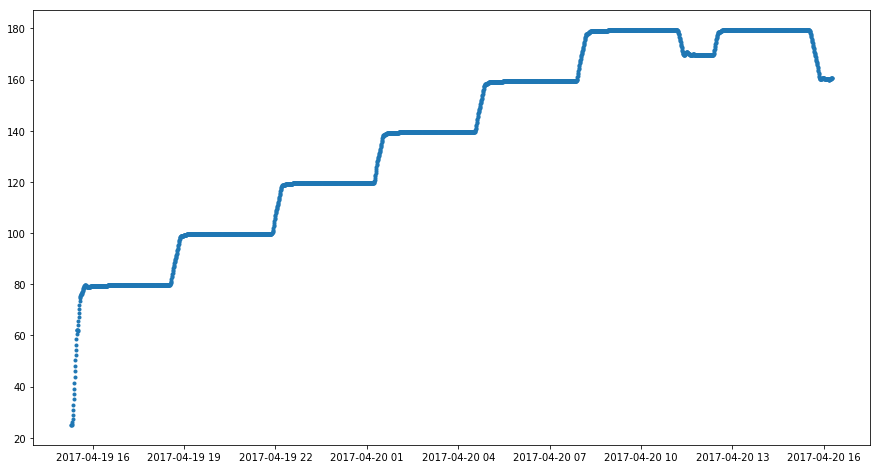

In [24]:
fig, ax = plt.subplots(figsize=(15,8))
ax.ticklabel_format(useOffset=False)
myFmt = mdates.DateFormatter('%Y-%m-%d %H') # set's the format of the timestamp on the x-axis
ax.xaxis.set_major_formatter(myFmt)


ax.plot(temperature_log_df.Timestamp, temperature_log_df.Reference_temperature, ".")

plt.show()

Now we can plot the the data from both sensors into one graph using the same time basis

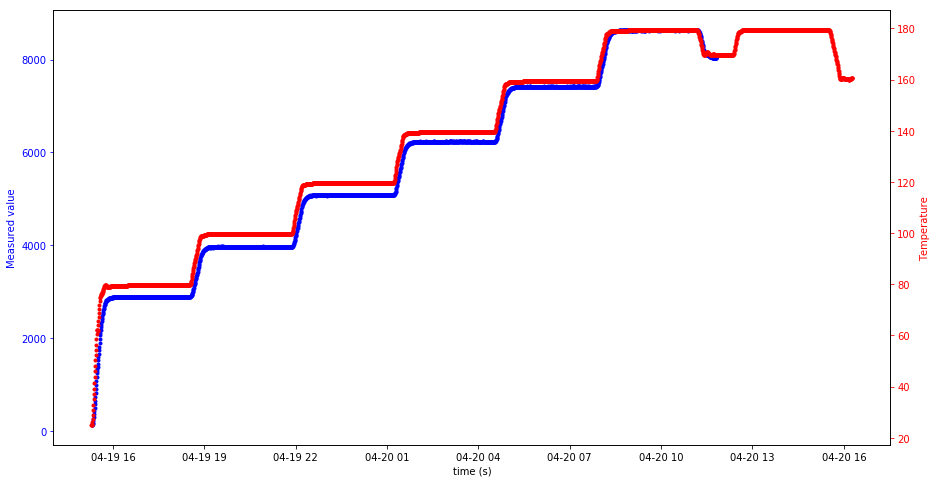

In [25]:
fig, ax1 = plt.subplots(figsize=(15,8))

myFmt = mdates.DateFormatter('%m.%d %H')
ax1.ticklabel_format(useOffset=False)

ax1.plot(logger1_df.Timestamp, logger1_df.Measured_value, 'b.')
ax1.set_xlabel('time (s)')
ax1.xaxis.set_major_formatter(myFmt)
ax1.set_ylabel('Measured value', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(temperature_log_df.Timestamp, temperature_log_df.Reference_temperature, 'r.')
ax2.set_ylabel('Temperature', color='r')
ax2.tick_params('y', colors='r')

plt.show()

This looks cool, there are a lot of things to do.

* The sampling speed is different in the log files - we need to synchronize the reference with the DUT
* The reference has faster thermal response than the DUT - we need to filter out only the stable parts from the data, wehre both sensors were stabilised on the same level (I will show this later, but I am speaking about the "flat" parts on the graph above)

Pandas has a useful feature to solve the synchronisation issue. We can resample the dataframe over a defined interval. I have chosen 30 seconds - Pandas divides the dataframe into 30 second long chunks, calculates the average value and adds this to a new dataframe (You can apply other functions than average, but in this case, this is the most useful one)

Inother words, at the end, both datasets will have th same timestamps -> we can merge them using these timestamps

In [26]:
temperature_log_resample_df = temperature_log_df.resample("30S",
                                                          on=temperature_log_df.columns[0]).mean()

In [43]:
temperature_log_resample_df.head()

Reference_temperature
Timestamp                                 
2017-04-19 15:17:30                 25.053
2017-04-19 15:18:00                 24.986
2017-04-19 15:18:30                 24.971
2017-04-19 15:19:00                 25.386
2017-04-19 15:19:30                 26.233

**Compare the head of the original and the new dataset**

In [28]:
temperature_log_df.head(10)

Timestamp  Reference_temperature
0 2017-04-19 15:17:37.076900                 25.053
1 2017-04-19 15:18:07.054900                 24.986
2 2017-04-19 15:18:37.080900                 24.971
3 2017-04-19 15:19:07.091900                 25.386
4 2017-04-19 15:19:37.117900                 26.233
5 2017-04-19 15:20:07.127900                 27.449
6 2017-04-19 15:20:37.138900                 29.071
7 2017-04-19 15:21:07.152900                 30.825
8 2017-04-19 15:21:37.079900                 32.769
9 2017-04-19 15:22:07.089900                 34.968

In [29]:
temperature_log_resample_df.head(10)

Reference_temperature
Timestamp                                 
2017-04-19 15:17:30                 25.053
2017-04-19 15:18:00                 24.986
2017-04-19 15:18:30                 24.971
2017-04-19 15:19:00                 25.386
2017-04-19 15:19:30                 26.233
2017-04-19 15:20:00                 27.449
2017-04-19 15:20:30                 29.071
2017-04-19 15:21:00                 30.825
2017-04-19 15:21:30                 32.769
2017-04-19 15:22:00                 34.968

In [30]:
logger1_resample_df = logger1_df.resample("30S",
                                          on=logger1_df.columns[0]).mean()

**Again, compare the head of the original and the new dataset**

In [31]:
logger1_df.head()

Timestamp  Measured_value
0 2017-04-19 15:18:02.209290             128
1 2017-04-19 15:18:32.209290             128
2 2017-04-19 15:19:06.209290             129
3 2017-04-19 15:19:40.209290             144
4 2017-04-19 15:20:10.209290             161

In [32]:
logger1_resample_df.head()

Measured_value
Timestamp                          
2017-04-19 15:18:00           128.0
2017-04-19 15:18:30           128.0
2017-04-19 15:19:00           129.0
2017-04-19 15:19:30           144.0
2017-04-19 15:20:00           161.0

Both log files are resampled, so they have the same time basis.

Now we can merge the data into one dataframe, works very similar to SQL's inner join

In [33]:
merge_df = pd.merge(logger1_resample_df,
                    temperature_log_resample_df,
                    how="inner",
                    left_index=True,
                    right_index=True)
merge_df = merge_df.dropna()

In [34]:
merge_df.describe()

Measured_value  Reference_temperature
count     2262.000000            2262.000000
mean      5704.632184             129.909402
std       2066.715263              35.636223
min        128.000000              24.971000
25%       3964.000000              99.696500
50%       6099.000000             138.562000
75%       7417.750000             159.450000
max       8644.000000             179.475000

In [35]:
merge_df.head()

Measured_value  Reference_temperature
Timestamp                                                 
2017-04-19 15:18:00           128.0                 24.986
2017-04-19 15:18:30           128.0                 24.971
2017-04-19 15:19:00           129.0                 25.386
2017-04-19 15:19:30           144.0                 26.233
2017-04-19 15:20:00           161.0                 27.449

How to find regions where the the data is 'flat' (temperature is stable) ?

There are two ways:

* Using standard deviation over the last n values
* Using slope over the last n values - slope is the coefficient m in the linear regression equation: y = m*x + b

In [36]:
# Defining a function for slope calculation

def slope(Y):
    A = np.array([ np.arange(0,len(Y)), np.ones(len(Y))])
    return np.linalg.lstsq(A.T,Y)[0][0]

The slope and the standard deviation is applied 15 sample long rolling window -> 15 sample = 15 * 30 seconds

So basically using either the slope or standard deviation, what was the variety of our data during the last 7.5 minutes

> Rolling means, that we are moving this 7.5 minute window from the beginning till the end

In [37]:
merge_df["stdev_meas_val"] = merge_df["Measured_value"].rolling(window=15,min_periods=1).std()
merge_df["stdev_ref_temp"] = merge_df["Reference_temperature"].rolling(window=15,min_periods=1).std()

In [38]:
merge_df.head()

Measured_value  Reference_temperature  stdev_meas_val  \
Timestamp                                                                    
2017-04-19 15:18:00           128.0                 24.986             NaN   
2017-04-19 15:18:30           128.0                 24.971        0.000000   
2017-04-19 15:19:00           129.0                 25.386        0.577350   
2017-04-19 15:19:30           144.0                 26.233        7.847505   
2017-04-19 15:20:00           161.0                 27.449       14.543040   

                     stdev_ref_temp  
Timestamp                            
2017-04-19 15:18:00             NaN  
2017-04-19 15:18:30        0.010607  
2017-04-19 15:19:00        0.235390  
2017-04-19 15:19:30        0.591433  
2017-04-19 15:20:00        1.052117

In [39]:
merge_df["slope_meas_val"] = merge_df["Measured_value"].rolling(window=15,min_periods=1).apply(slope, raw=True)
merge_df["slope_ref_temp"] = merge_df["Reference_temperature"].rolling(window=15,min_periods=1).apply(slope, raw=True)

In [40]:
merge_df["TimeCopy"] = merge_df.index

In [41]:
merge_df.head()

Measured_value  Reference_temperature  stdev_meas_val  \
Timestamp                                                                    
2017-04-19 15:18:00           128.0                 24.986             NaN   
2017-04-19 15:18:30           128.0                 24.971        0.000000   
2017-04-19 15:19:00           129.0                 25.386        0.577350   
2017-04-19 15:19:30           144.0                 26.233        7.847505   
2017-04-19 15:20:00           161.0                 27.449       14.543040   

                     stdev_ref_temp  slope_meas_val  slope_ref_temp  \
Timestamp                                                             
2017-04-19 15:18:00             NaN    0.000000e+00          0.0000   
2017-04-19 15:18:30        0.010607   -2.131628e-14         -0.0150   
2017-04-19 15:19:00        0.235390    5.000000e-01          0.2000   
2017-04-19 15:19:30        0.591433    4.900000e+00          0.4156   
2017-04-19 15:20:00        1.052117    8.200000e+00          0.6188   

                               TimeCopy  
Timestamp                                
2017-04-19 15:18:00 2017-04-19 15:18:00  
2017-04-19 15:18:30 2017-04-19 15:18:30  
2017-04-19 15:19:00 2017-04-19 15:19:00  
2017-04-19 15:19:30 2017-04-19 15:19:30  
2017-04-19 15:20:00 2017-04-19 15:20:00

Why are these slopes and standard deviations useful for us? 

See the next plot:

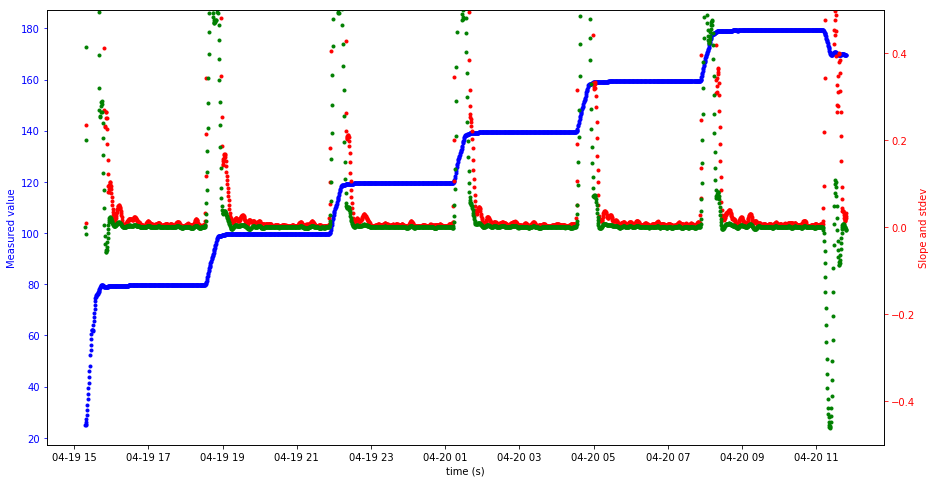

In [42]:
fig, ax1 = plt.subplots(figsize=(15,8))

myFmt = mdates.DateFormatter('%m.%d %H')
ax1.ticklabel_format(useOffset=False)

ax1.plot(merge_df.index, merge_df['Reference_temperature'], 'b.')

ax1.set_xlabel('time (s)')
ax1.xaxis.set_major_formatter(myFmt)
ax1.set_ylabel('Measured value', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(merge_df.index, merge_df['stdev_ref_temp'], 'r.')
ax2.plot(merge_df.index, merge_df['slope_ref_temp'], 'g.')
ax2.set_ylabel('Slope and stdev', color='r')
ax2.tick_params('y', colors='r')
ax2.set_ylim(-0.5, 0.5)

plt.show()

The measured value is stable, when the slope, or stdev is very close to zero


In [44]:


%gui qt
from glue import qglue



In [45]:
app = qglue(xy=merge_df)